# 01 — Data Assembly: Triple Essentiality Table

Build the integrated gene table combining TnSeq essentiality, FBA predictions,
and mutant growth rates for *A. baylyi* ADP1. Also join per-condition FBA flux
from `gene_phenotypes` and pangenome annotations from `cluster_id_mapping.csv`.

**Output**: `data/triple_gene_table.csv`

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 150

DB_PATH = Path('../user_data/berdl_tables.db')
DATA_DIR = Path('../data')
FIG_DIR = Path('../figures')
FIG_DIR.mkdir(exist_ok=True)

conn = sqlite3.connect(DB_PATH)
print(f'Connected to {DB_PATH}')

Connected to ../user_data/berdl_tables.db


## 1. Load genome_features

In [2]:
gf = pd.read_sql('SELECT * FROM genome_features', conn)

growth_cols = [c for c in gf.columns if c.startswith('mutant_growth_')]
condition_names = [c.replace('mutant_growth_', '') for c in growth_cols]

print(f'Total genes: {len(gf):,}')
print(f'Growth conditions: {condition_names}')
print(f'\nData availability:')
print(f'  TnSeq (minimal): {gf["essentiality_minimal"].notna().sum():,}')
print(f'  TnSeq (LB):      {gf["essentiality_lb"].notna().sum():,}')
print(f'  FBA (minimal):    {gf["minimal_media_class"].notna().sum():,}')
print(f'  FBA (rich):       {gf["rich_media_class"].notna().sum():,}')
print(f'  Any growth data:  {gf[growth_cols].notna().any(axis=1).sum():,}')

Total genes: 5,852
Growth conditions: ['acetate', 'asparagine', 'butanediol', 'glucarate', 'glucose', 'lactate', 'quinate', 'urea']

Data availability:
  TnSeq (minimal): 3,405
  TnSeq (LB):      3,405
  FBA (minimal):    866
  FBA (rich):       866
  Any growth data:  2,350


## 2. Define the Triple-Covered Gene Set

Genes with all three measures: TnSeq essentiality (minimal), FBA class (minimal), and at least one growth measurement.

In [3]:
has_tnseq = gf['essentiality_minimal'].notna()
has_fba = gf['minimal_media_class'].notna()
has_growth = gf[growth_cols].notna().any(axis=1)

triple_mask = has_tnseq & has_fba & has_growth
triple = gf[triple_mask].copy()

print(f'Triple-covered genes: {len(triple)}')
print(f'\nTnSeq essentiality distribution (minimal media):')
print(triple['essentiality_minimal'].value_counts())
print(f'\nFBA class distribution (minimal media):')
print(triple['minimal_media_class'].value_counts())
print(f'\nNote: All triple-covered genes are TnSeq-dispensable because')
print(f'TnSeq-essential genes have no viable deletion mutants for growth assays.')

Triple-covered genes: 478

TnSeq essentiality distribution (minimal media):
essentiality_minimal
dispensable    478
Name: count, dtype: int64

FBA class distribution (minimal media):
minimal_media_class
variable     204
blocked      196
essential     78
Name: count, dtype: int64

Note: All triple-covered genes are TnSeq-dispensable because
TnSeq-essential genes have no viable deletion mutants for growth assays.


## 3. Growth Rate Distributions and Defect Thresholds

Define per-condition growth defect thresholds. We use the 25th percentile of each
condition's growth rate distribution as the defect cutoff — genes below this
threshold are classified as having a growth defect on that condition.

In [4]:
# Compute per-condition statistics for triple genes
stats_rows = []
for col, cond in zip(growth_cols, condition_names):
    vals = triple[col].dropna()
    stats_rows.append({
        'condition': cond,
        'n_genes': len(vals),
        'median': vals.median(),
        'mean': vals.mean(),
        'std': vals.std(),
        'q25': vals.quantile(0.25),
        'q75': vals.quantile(0.75),
        'min': vals.min(),
        'max': vals.max(),
    })

growth_stats = pd.DataFrame(stats_rows)
print('Growth rate statistics per condition (triple genes):')
display(growth_stats.round(3))

Growth rate statistics per condition (triple genes):


,condition,n_genes,median,mean,std,q25,q75,min,max
0,acetate,456,0.558,0.548,0.135,0.469,0.653,-0.014,0.764
1,asparagine,468,0.806,0.787,0.114,0.752,0.851,-0.032,1.077
2,butanediol,466,0.645,0.624,0.147,0.565,0.717,-0.012,0.853
3,glucarate,449,1.274,1.251,0.165,1.201,1.334,-0.032,1.496
4,glucose,459,1.318,1.284,0.208,1.251,1.390,-0.021,1.512
5,lactate,469,0.816,0.797,0.108,0.758,0.855,0.005,0.978
6,quinate,464,1.365,1.313,0.256,1.308,1.416,-0.045,1.552
7,urea,468,0.407,0.400,0.067,0.382,0.433,0.016,0.571


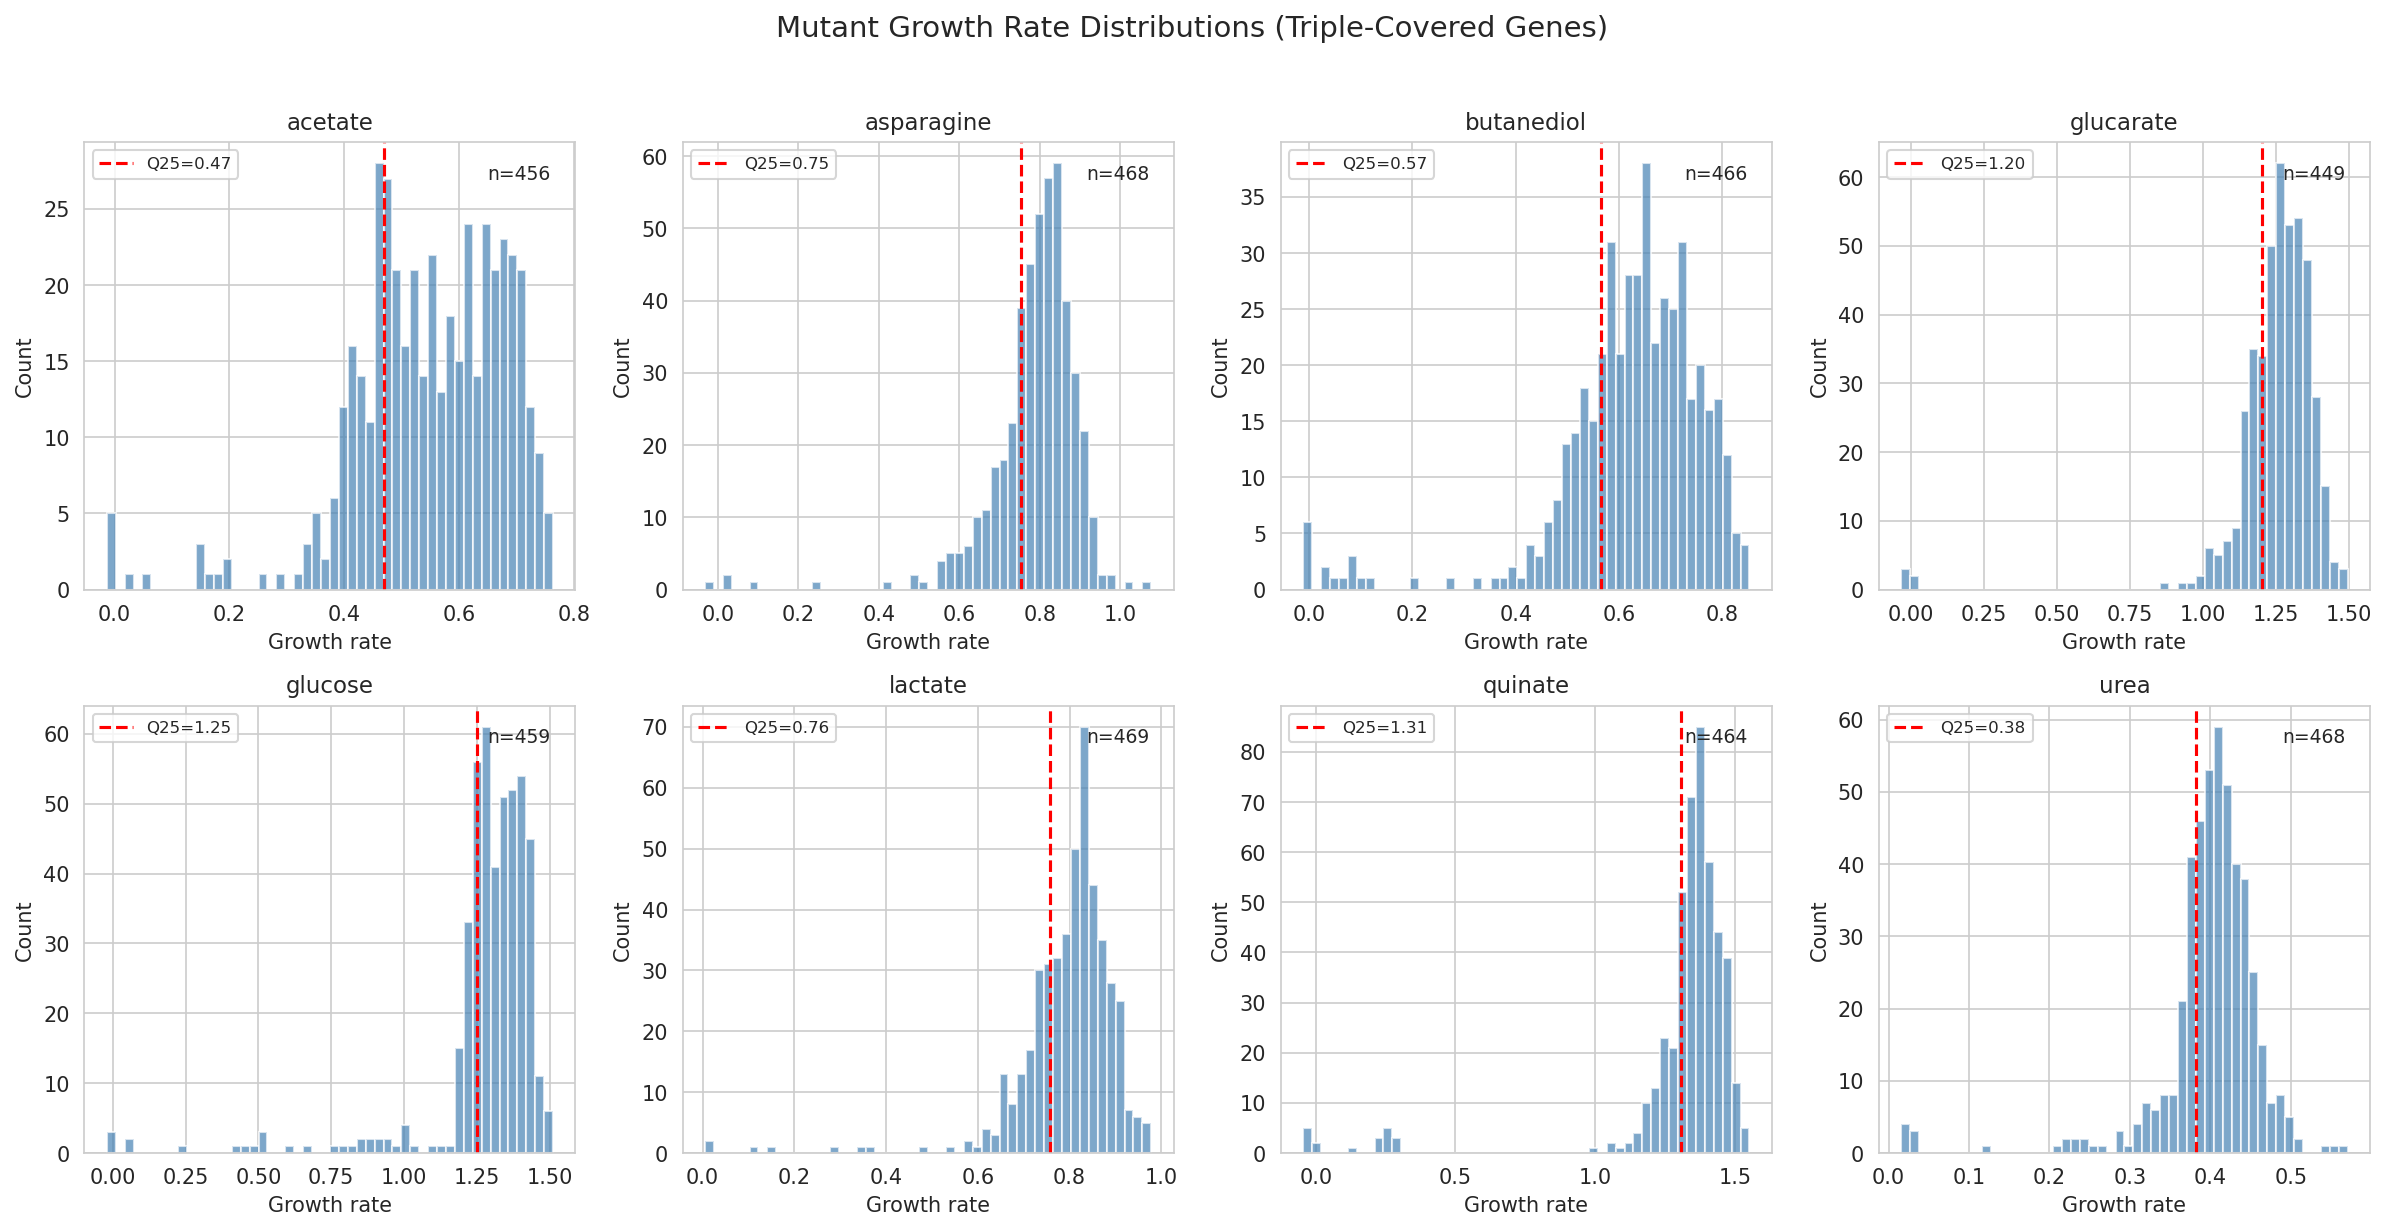

In [5]:
# Visualize growth rate distributions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, (col, cond) in enumerate(zip(growth_cols, condition_names)):
    vals = triple[col].dropna()
    ax = axes[i]
    ax.hist(vals, bins=50, color='steelblue', alpha=0.7, edgecolor='white')
    q25 = vals.quantile(0.25)
    ax.axvline(q25, color='red', linestyle='--', linewidth=1.5, label=f'Q25={q25:.2f}')
    ax.set_title(cond, fontsize=11)
    ax.set_xlabel('Growth rate')
    ax.set_ylabel('Count')
    ax.legend(fontsize=8)
    ax.text(0.95, 0.95, f'n={len(vals)}', transform=ax.transAxes,
            ha='right', va='top', fontsize=9)

plt.suptitle('Mutant Growth Rate Distributions (Triple-Covered Genes)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(FIG_DIR / 'growth_rate_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

In [6]:
# Create binary growth_important flags per condition using Q25 threshold
# Use pd.array with BooleanDtype to support NaN in boolean columns
for col, cond in zip(growth_cols, condition_names):
    vals = triple[col]
    q25 = vals.dropna().quantile(0.25)
    # Use nullable boolean to handle NaN properly
    defect = pd.array(vals < q25, dtype=pd.BooleanDtype())
    defect[vals.isna()] = pd.NA
    triple[f'growth_defect_{cond}'] = defect

# Create an "any growth defect" flag (across all conditions with data)
defect_cols = [f'growth_defect_{c}' for c in condition_names]
triple['any_growth_defect'] = triple[defect_cols].any(axis=1).fillna(False).astype(bool)

print('Growth defect counts per condition (Q25 threshold):')
for cond in condition_names:
    col = f'growth_defect_{cond}'
    n_defect = triple[col].sum()
    n_total = triple[col].notna().sum()
    print(f'  {cond:>12}: {n_defect:3.0f}/{n_total} ({n_defect/n_total*100:.0f}%) with defect')

print(f'\nAny growth defect: {triple["any_growth_defect"].sum()}/{len(triple)}'
      f' ({triple["any_growth_defect"].mean()*100:.0f}%)')

Growth defect counts per condition (Q25 threshold):
       acetate: 114/456 (25%) with defect
    asparagine: 117/468 (25%) with defect
    butanediol: 117/466 (25%) with defect
     glucarate: 112/449 (25%) with defect
       glucose: 115/459 (25%) with defect
       lactate: 117/469 (25%) with defect
       quinate: 116/464 (25%) with defect
          urea: 117/468 (25%) with defect

Any growth defect: 343/478 (72%)


## 4. Per-Condition FBA Flux from gene_phenotypes

Load FBA flux predictions for matched carbon sources from the `gene_phenotypes` table.

In [7]:
# Map growth conditions to gene_phenotypes phenotype names
condition_to_phenotype = {
    'glucose': 'D Glucose',
    'acetate': 'Acetic Acid',
    'asparagine': 'L Asparagine',
    'butanediol': '2 3 Butanediol',
    'glucarate': 'Glucarate',
    'lactate': 'Lactate',
    # quinate and urea have no matching FBA predictions
}

# Load gene_phenotypes for ADP1 RAST genome
gp = pd.read_sql(
    "SELECT gene_id, phenotype_name, model_pred_max_flux "
    "FROM gene_phenotypes "
    "WHERE genome_id = 'user_Acinetobacter_baylyi_ADP1_RAST'",
    conn
)
print(f'Total ADP1 gene_phenotypes rows: {len(gp):,}')

# Pivot to get per-condition flux columns
flux_data = {}
for cond, pheno_name in condition_to_phenotype.items():
    subset = gp[gp['phenotype_name'] == pheno_name][['gene_id', 'model_pred_max_flux']]
    subset = subset.rename(columns={'model_pred_max_flux': f'fba_flux_{cond}'})
    flux_data[cond] = subset
    print(f'  {cond} ({pheno_name}): {len(subset)} genes with FBA flux')

# Join flux data to triple table
for cond, flux_df in flux_data.items():
    triple = triple.merge(
        flux_df, left_on='feature_id', right_on='gene_id', how='left'
    ).drop(columns=['gene_id'], errors='ignore')

flux_cols = [f'fba_flux_{c}' for c in condition_to_phenotype.keys()]
print(f'\nTriple genes with per-condition FBA flux:')
for col in flux_cols:
    cond = col.replace('fba_flux_', '')
    n = triple[col].notna().sum()
    print(f'  {cond:>12}: {n} genes')

Total ADP1 gene_phenotypes rows: 169,085
  glucose (D Glucose): 1824 genes with FBA flux
  acetate (Acetic Acid): 1529 genes with FBA flux
  asparagine (L Asparagine): 1272 genes with FBA flux
  butanediol (2 3 Butanediol): 448 genes with FBA flux
  glucarate (Glucarate): 428 genes with FBA flux
  lactate (Lactate): 444 genes with FBA flux

Triple genes with per-condition FBA flux:
       glucose: 406 genes
       acetate: 373 genes
    asparagine: 293 genes
    butanediol: 140 genes
     glucarate: 131 genes
       lactate: 139 genes


## 5. Pangenome Annotations

Join cluster ID mapping to add core/accessory status from the BERDL pangenome.

In [8]:
# Load cluster ID mapping
cluster_map = pd.read_csv(DATA_DIR / 'cluster_id_mapping.csv')
print(f'Cluster ID mappings: {len(cluster_map)}')
print(f'Core: {cluster_map["is_core"].sum()}, '
      f'Auxiliary: {cluster_map["is_auxiliary"].sum()}, '
      f'Singleton: {cluster_map["is_singleton"].sum()}')

# The genome_features table has pangenome_is_core already
# Let's verify and use the existing annotation
print(f'\nPangenome status in triple genes (from genome_features):')
print(f'  Has pangenome_is_core: {triple["pangenome_is_core"].notna().sum()}')
print(triple['pangenome_is_core'].value_counts())

Cluster ID mappings: 4891
Core: 3207, Auxiliary: 1684, Singleton: 1521

Pangenome status in triple genes (from genome_features):
  Has pangenome_is_core: 477
pangenome_is_core
1.0    460
0.0     17
Name: count, dtype: int64


In [9]:
# Join cluster_id_mapping for richer pangenome info
# Deduplicate cluster_map on adp1_cluster_id (multiple berdl clusters can map
# to the same adp1 cluster — take majority vote on core/aux/singleton)
cluster_dedup = cluster_map.groupby('adp1_cluster_id').agg({
    'is_core': 'any',  # core if any mapping says core
    'is_auxiliary': 'any',
    'is_singleton': 'any',
}).reset_index()
print(f'Cluster map: {len(cluster_map)} rows -> {len(cluster_dedup)} unique adp1_cluster_ids')

triple = triple.merge(
    cluster_dedup,
    left_on='pangenome_cluster_id',
    right_on='adp1_cluster_id',
    how='left'
).drop(columns=['adp1_cluster_id'], errors='ignore')

# Rename to avoid confusion with the genome_features pangenome_is_core
triple = triple.rename(columns={
    'is_core': 'cluster_is_core',
    'is_auxiliary': 'cluster_is_auxiliary',
    'is_singleton': 'cluster_is_singleton'
})

print(f'Cluster mapping match rate: {triple["cluster_is_core"].notna().sum()}/{len(triple)}')
print(f'Row count after join: {len(triple)} (should still be 478)')

Cluster map: 4891 rows -> 4081 unique adp1_cluster_ids
Cluster mapping match rate: 477/478
Row count after join: 478 (should still be 478)


## 6. Create Derived Columns for Analysis

In [10]:
# Binarize FBA: essential vs non-essential (variable + blocked)
triple['fba_essential'] = (triple['minimal_media_class'] == 'essential').astype(bool)

# TnSeq: already have essentiality_minimal (all dispensable in triple set)
triple['tnseq_essential'] = (triple['essentiality_minimal'] == 'essential').astype(bool)

# Create a concordance class
def classify_concordance(row):
    fba = row['minimal_media_class']
    growth = row['any_growth_defect']
    if fba == 'essential' and growth:
        return 'FBA-essential + growth-defect'
    elif fba == 'essential' and not growth:
        return 'FBA-essential + growth-normal'
    elif fba == 'variable' and growth:
        return 'FBA-variable + growth-defect'
    elif fba == 'variable' and not growth:
        return 'FBA-variable + growth-normal'
    elif fba == 'blocked' and growth:
        return 'FBA-blocked + growth-defect'
    elif fba == 'blocked' and not growth:
        return 'FBA-blocked + growth-normal'
    return 'other'

triple['concordance_class'] = triple.apply(classify_concordance, axis=1)

print('Concordance classes:')
print(triple['concordance_class'].value_counts())

print(f'\nFBA essential: {triple["fba_essential"].sum()}')
print(f'TnSeq essential: {triple["tnseq_essential"].sum()}')
print(f'Any growth defect: {triple["any_growth_defect"].sum()}')

Concordance classes:
concordance_class
FBA-variable + growth-defect     150
FBA-blocked + growth-defect      136
FBA-blocked + growth-normal       60
FBA-essential + growth-defect     57
FBA-variable + growth-normal      54
FBA-essential + growth-normal     21
Name: count, dtype: int64

FBA essential: 78
TnSeq essential: 0
Any growth defect: 343


## 7. Summary and Save

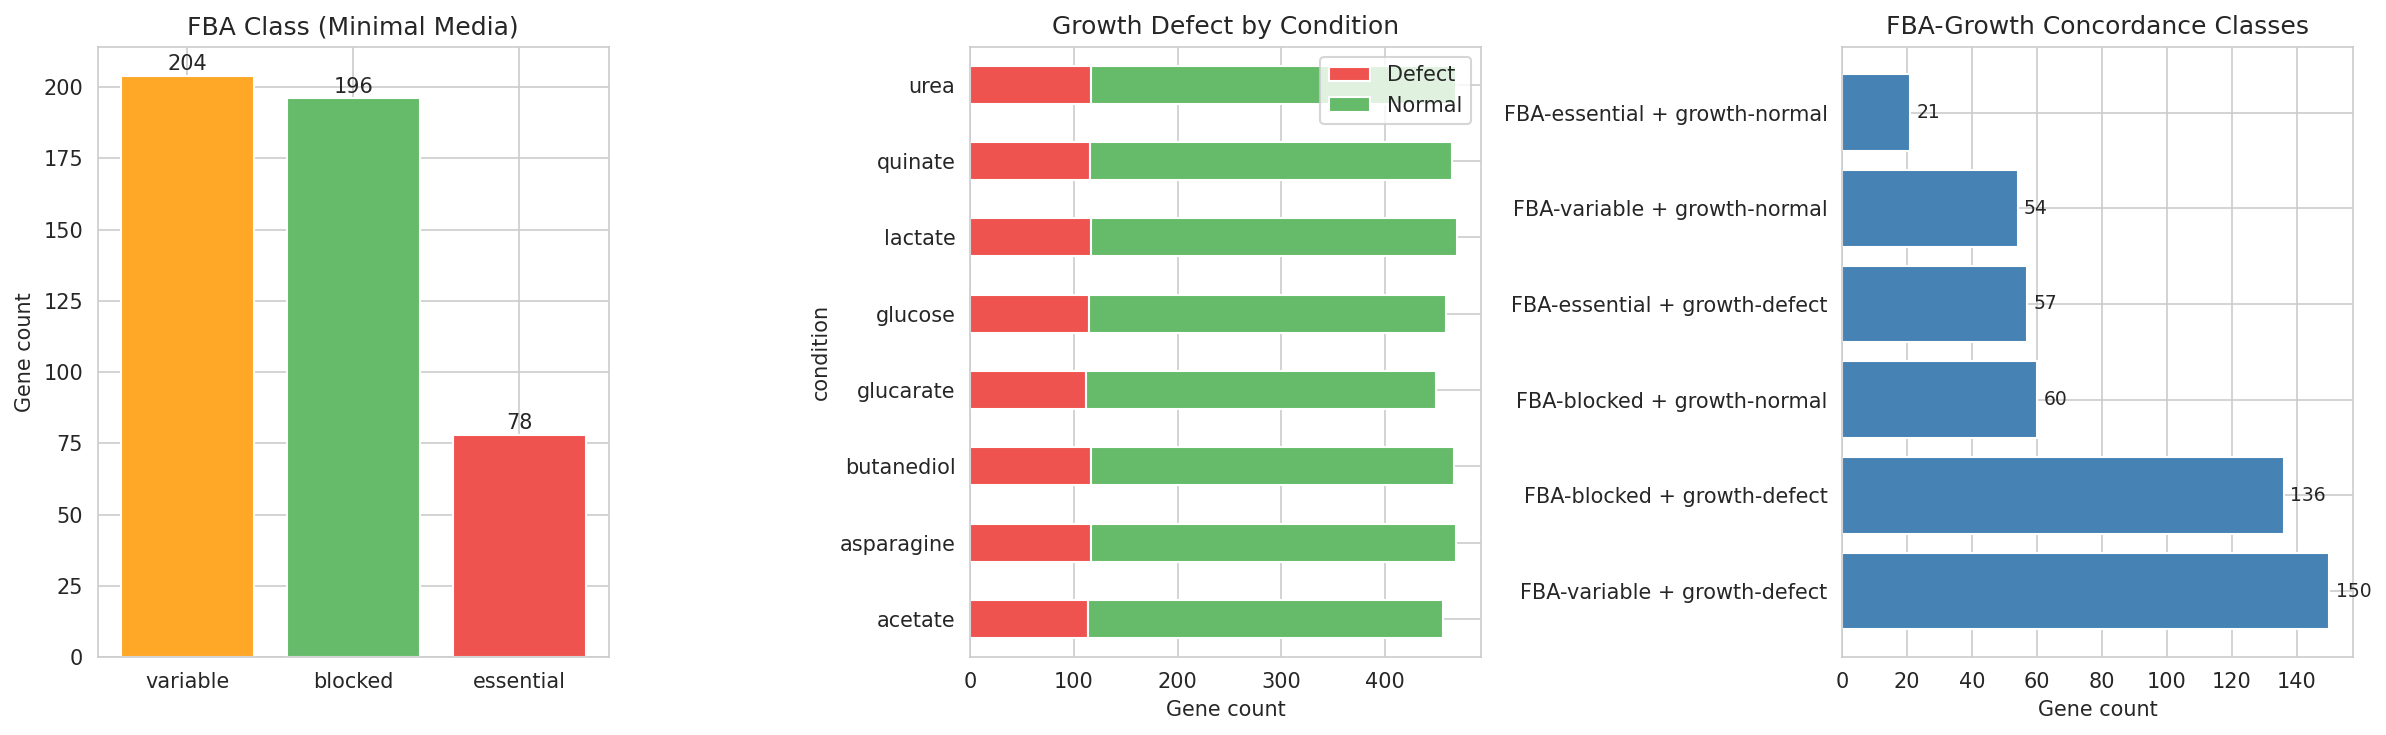

In [11]:
# Summary figure: data availability overview
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1: FBA class distribution
fba_colors = {'essential': '#EF5350', 'variable': '#FFA726', 'blocked': '#66BB6A'}
fba_counts = triple['minimal_media_class'].value_counts()
bars = axes[0].bar(fba_counts.index, fba_counts.values,
                    color=[fba_colors.get(x, 'gray') for x in fba_counts.index])
axes[0].set_title('FBA Class (Minimal Media)', fontsize=12)
axes[0].set_ylabel('Gene count')
for bar, val in zip(bars, fba_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                 str(val), ha='center', fontsize=10)

# Panel 2: Growth defect by condition
defect_counts = []
for cond in condition_names:
    col = f'growth_defect_{cond}'
    n_defect = triple[col].sum()
    n_total = triple[col].notna().sum()
    defect_counts.append({'condition': cond, 'defect': n_defect, 'normal': n_total - n_defect})
defect_df = pd.DataFrame(defect_counts).set_index('condition')
defect_df.plot(kind='barh', stacked=True, ax=axes[1],
               color=['#EF5350', '#66BB6A'])
axes[1].set_title('Growth Defect by Condition', fontsize=12)
axes[1].set_xlabel('Gene count')
axes[1].legend(['Defect', 'Normal'])

# Panel 3: Concordance class distribution
cc = triple['concordance_class'].value_counts()
axes[2].barh(cc.index, cc.values, color='steelblue')
axes[2].set_title('FBA-Growth Concordance Classes', fontsize=12)
axes[2].set_xlabel('Gene count')
for i, (idx, val) in enumerate(cc.items()):
    axes[2].text(val + 2, i, str(val), va='center', fontsize=9)

plt.tight_layout()
plt.savefig(FIG_DIR / 'data_assembly_overview.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# Save the assembled table
output_cols = (
    ['feature_id', 'genome_id', 'contig_id', 'length', 'start', 'end', 'strand',
     'bakta_function', 'rast_function', 'cog', 'ec', 'gene_names', 'ko',
     'pangenome_cluster_id', 'pangenome_is_core',
     'rich_media_flux', 'rich_media_class',
     'minimal_media_flux', 'minimal_media_class',
     'essentiality_minimal', 'essentiality_lb',
     'old_locus_tag']
    + growth_cols
    + defect_cols
    + ['any_growth_defect', 'fba_essential', 'tnseq_essential', 'concordance_class']
    + flux_cols
    + ['cluster_is_core', 'cluster_is_auxiliary', 'cluster_is_singleton']
)

# Only keep columns that exist
output_cols = [c for c in output_cols if c in triple.columns]
triple_out = triple[output_cols]

triple_out.to_csv(DATA_DIR / 'triple_gene_table.csv', index=False)
print(f'Saved {len(triple_out)} genes x {len(output_cols)} columns to data/triple_gene_table.csv')
print(f'\nColumn summary:')
for col in output_cols:
    n_valid = triple_out[col].notna().sum()
    print(f'  {col:<35} {n_valid:>4} non-null')

Saved 478 genes x 51 columns to data/triple_gene_table.csv

Column summary:
  feature_id                           478 non-null
  genome_id                            478 non-null
  contig_id                            478 non-null
  length                               478 non-null
  start                                478 non-null
  end                                  478 non-null
  strand                               478 non-null
  bakta_function                       478 non-null
  rast_function                        478 non-null
  cog                                   62 non-null
  ec                                   347 non-null
  gene_names                           258 non-null
  ko                                   407 non-null
  pangenome_cluster_id                 477 non-null
  pangenome_is_core                    477 non-null
  rich_media_flux                      478 non-null
  rich_media_class                     478 non-null
  minimal_media_flux                   4

In [13]:
conn.close()
print('Done. Data assembly complete.')

Done. Data assembly complete.
